## Jump Only ##

In [1]:
#Import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline
import numpy as np
from scipy.optimize import fsolve


In [2]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)

In [ ]:
#Parameters

# Jump only lambda_v = 0, sigma_v = 0,  lambda_r=0, sigma_r=0

#Simulation parameters
T = 1.0         # Time horizon (years)
N = 252         # Number of time steps
dt = T / N      # Time increment
M = 10000        # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                           # Speed of mean reversion for interest rate                             # Escobar
varphi_r= 0.0025                                        # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0 #0.0566                                      # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                                 # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = 0 #-0.1132                                   # Market price of risk                                                  # Escobar
T_tilde = T                                             # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                     # Speed of mean reversion for variance                                                          # Escobar
varphi_v= 0.0563                                     # varphi_v/kappa_v is the long-run variance level set to 0.13**2 as per Liu and Pan 2003        # Escobar
sigma_v = 0 #0.2941                                  # Volatility of variance process                                                                # Escobar
V0 = varphi_v / kappa_v                              # Initial variance                                                                              # Escobar    
rho = -0.23                                          # Correlation between stock and variance                                                        # Escobar                                  
lambda_v= 0 #-6.6932                                 # Risk premium on variance                                                                      # Escobar                 

# Parameters for stock price process
S0 = 100                                             # Initial stock price                                                                           # Escobar
lambda_s = 2.2472                                    # Risk premium on diffusive risk                                                                # Escobar                        
nu= -0.5973                                          # Factor loading stock and rate                                                                 # Escobar 
lambda_j = 12.3                                      # Jump intensity                                                                                # Pan
lambda_j_q = lambda_j*2                              # Jump intensity Q                                                                              # Liu and Pan
mu= -0.10                                            # Jump amplitude                                                                                # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                       # Jump intensity

# Parameters for option pricing 
num_K= 9                                             # Number of strikes     

# General parameters
gamma= 3                                             # Risk aversion parameter      


In [5]:
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    exp_term = np.exp(xi * (T_tilde - t)) - 1
    num = 2 * exp_term
    den = 2 * xi + (xi + kappa_r + lambda_r) * exp_term

    if np.isnan(num) or np.isnan(den) or den == 0:
        return 0.0

    return num / den

In [6]:
print("Expected return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Expected return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

expected_return=r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0

Expected return on stock:  0.08726051289494172
Expected return on bond:  0.019230769230769232


In [7]:
# Allocate result arrays
call_prices = np.zeros((M, N + 1, num_K))
put_prices = np.zeros((M, N + 1, num_K))
delta_call = np.zeros((M, N + 1, num_K))
delta_put = np.zeros((M, N + 1, num_K))
vega_call = np.zeros((M, N + 1, num_K))
vega_put = np.zeros((M, N + 1, num_K))
rho_call = np.zeros((M, N + 1, num_K))
rho_put = np.zeros((M, N + 1, num_K))
jump_call = np.zeros((M, N + 1, num_K))
jump_put = np.zeros((M, N + 1, num_K))

# Paths
S_paths = np.zeros((M, N + 1))
V_paths = np.zeros((M, N + 1))
r_paths = np.zeros((M, N + 1))
dN = np.zeros((M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1)) 
B= np.zeros((M, N + 1))
M_t= np.zeros((M, N + 1))
dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))

sqrt_1_minus_rho2 = np.sqrt(1 - rho**2)

def simulation(S_t, V_t, r_t):
    S_paths[:, 0] = S_t
    V_paths[:, 0] = V_t
    r_paths[:, 0] = r_t
    B[:, 0] = 1
    M_t[:, 0] = 1

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock Diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + sqrt_1_minus_rho2 * dW_s[:, j]) * S_prev+ nu*sigma_r*np.sqrt(r_prev)*dW_r[:, j]*S_prev
        
        # Jump Term
        jump_term = S_prev * mu * (N_J[:, j]- lambda_j * V_prev * dt)
        
        # Stock Drift
        drift = (r_prev+lambda_v*rho*V_prev+lambda_s*sqrt_1_minus_rho2*V_prev+nu*lambda_r*r_prev+mu*(lambda_j-lambda_j_q)*V_prev) * S_prev * dt

        # Stock Process
        S_new = S_prev + drift + diffusion + jump_term

        # Money Market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)


        # Bond Process
        t_curr= j *dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t*r_prev) * B[:, j - 1] * dt
        diffusion_B =  -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

    return S_paths, V_paths, r_paths

simulation(S0, V0, r0)

def simulate_bumped_V_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    V_bumped = np.maximum(V_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_bumped * dt)
    drift = (r_curr + lambda_v * rho * V_bumped + lambda_s * np.sqrt(1 - rho**2) * V_bumped +
             nu * lambda_r * r_curr + mu * (lambda_j - lambda_j_q) * V_bumped) * S_curr * dt
    diffusion = (np.sqrt(V_bumped) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_curr) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def simulate_bumped_r_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    r_bumped = np.maximum(r_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_curr * dt)
    drift = (r_bumped + lambda_v * rho * V_curr + lambda_s * np.sqrt(1 - rho**2) * V_curr +
             nu * lambda_r * r_bumped + mu * (lambda_j - lambda_j_q) * V_curr) * S_curr * dt
    diffusion = (np.sqrt(V_curr) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_bumped) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def numerical_option_pricing(S, K):
    return max(S - K, 0), max(K - S, 0)

epsilon_S = 1e-4
epsilon_V = 1e-3  # for Vega
epsilon_r = 1e-3  # for Rho

for i in tqdm(range(M), desc="Simulating Monte Carlo Paths"):
    for j in range(N + 1):
        S_mean = np.mean(S_paths[:, j])
        strike_prices = np.linspace(S_mean * 0.8, S_mean * 1.2, num_K)
        S_curr = S_paths[i, j]
        S_bump_S_up = S_curr + epsilon_S
        S_bump_S_down = S_curr - epsilon_S
        S_bump_jump = S_curr * (1 + mu)

        S_bumped_V = simulate_bumped_V_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_V)
        S_bumped_r = simulate_bumped_r_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_r)

        for k, K in enumerate(strike_prices):
            call, put = numerical_option_pricing(S_curr, K)
            call_prices[i, j, k] = call
            put_prices[i, j, k] = put
            call_V, put_V = numerical_option_pricing(S_bumped_V, K)
            call_r, put_r = numerical_option_pricing(S_bumped_r, K)
            call_S_up, put_S_up = numerical_option_pricing(S_bump_S_up, K)
            call_S_down, put_S_down = numerical_option_pricing(S_bump_S_down, K)
            call_J, put_J = numerical_option_pricing(S_bump_jump, K)

            delta_call[i, j, k] = (call_S_up - call_S_down) / (epsilon_S*2)
            delta_put[i, j, k] = (put_S_up - put_S_down) / (epsilon_S*2)
            vega_call[i, j, k] = (call_V - call) / epsilon_V
            vega_put[i, j, k] = (put_V - put) / epsilon_V
            rho_call[i, j, k] = (call_r - call) / epsilon_r
            rho_put[i, j, k] = (put_r - put) / epsilon_r
            jump_call[i, j, k] = (call_J - call) #/ mu
            jump_put[i, j, k] = (put_J - put) #/ mu

print("Simulation and pricing complete!")

S=S_paths
V=V_paths
r=r_paths

Simulating Monte Carlo Paths: 100%|██████████| 10000/10000 [02:10<00:00, 76.68it/s]

Simulation and pricing complete!


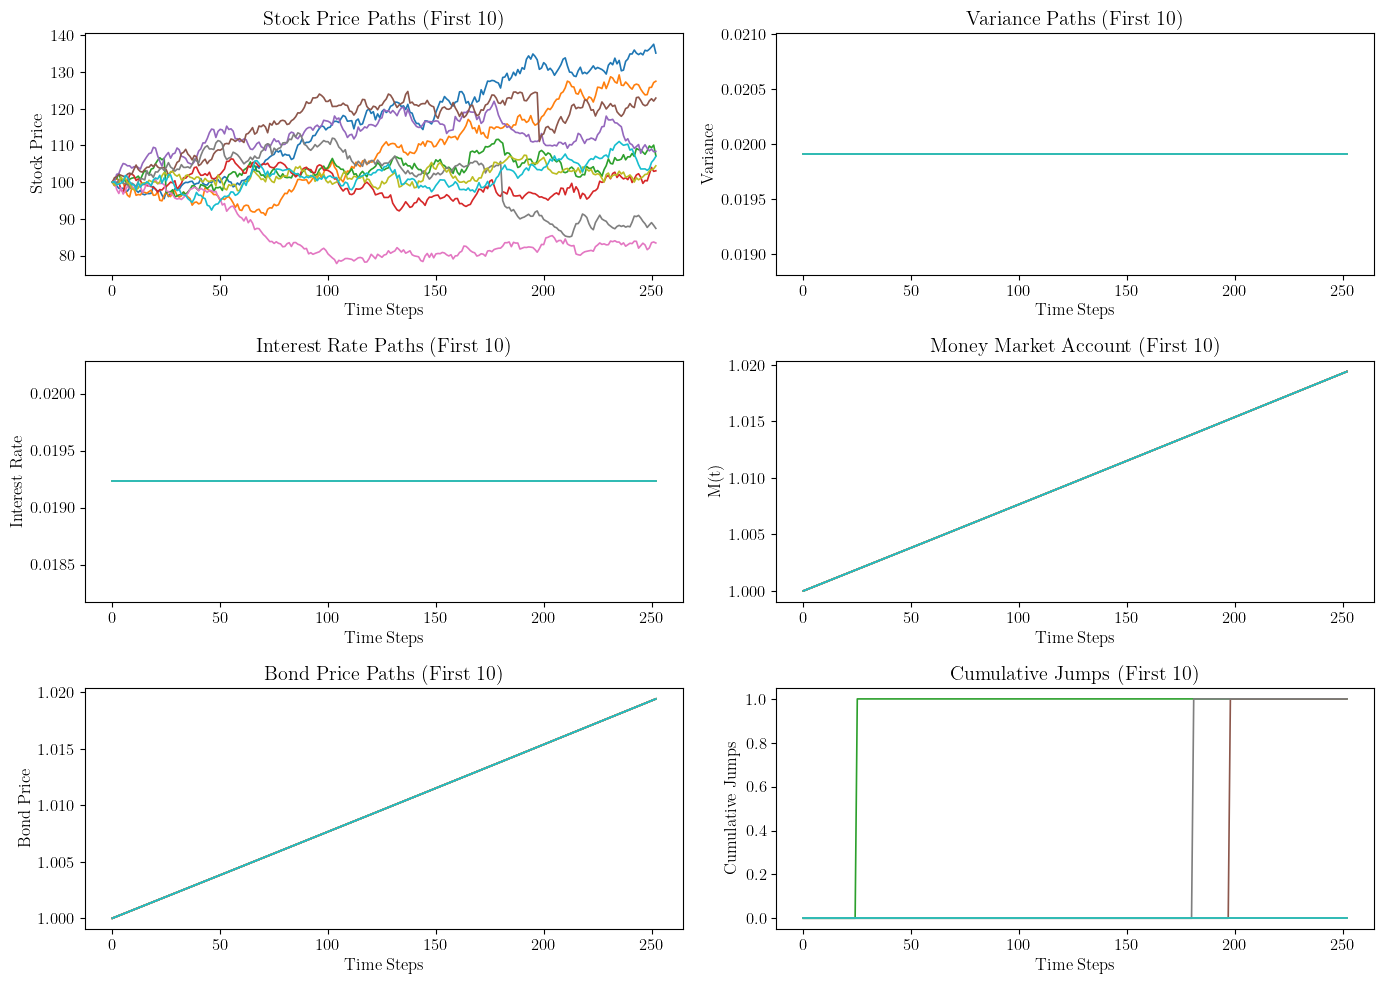

In [8]:
def plot_paths(S, V, r, M_t, B, dN, dN_J, call_prices, put_prices, num_paths=10):
    S = S[:num_paths]
    V = V[:num_paths]
    r = r[:num_paths]
    M_t = M_t[:num_paths]
    B = B[:num_paths]
    dN = dN[:num_paths]
    dN_J = dN_J[:num_paths]
    call_prices= call_prices[:num_paths,:,4]
    put_prices= put_prices[:num_paths,:,4]

    plt.figure(figsize=(14, 10))

    plt.subplot(3, 2, 1)
    plt.plot(S.T, linewidth=1.2)
    plt.title("Stock Price Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")

    plt.subplot(3, 2, 2)
    plt.plot(V.T, linewidth=1.2)
    plt.title("Variance Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Variance")

    plt.subplot(3, 2, 3)
    plt.plot(r.T, linewidth=1.2)
    plt.title("Interest Rate Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Interest Rate")

    plt.subplot(3, 2, 4)
    plt.plot(M_t.T, linewidth=1.2)
    plt.title("Money Market Account (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("M(t)")

    plt.subplot(3, 2, 5)
    plt.plot(B.T, linewidth=1.2)
    plt.title("Bond Price Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Bond Price")

    plt.subplot(3, 2, 6)
    cumulative_jumps = np.cumsum(dN_J, axis=1)
    plt.plot(cumulative_jumps.T, linewidth=1.2)
    plt.title("Cumulative Jumps (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Jumps")
    
    plt.tight_layout()
    plt.show()

# Now call the plotting function with your simulation results
plot_paths(S, V, r, M_t, B, dN, N_J, call_prices, put_prices, num_paths=10)


In [ ]:
def compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j):
    k1_v = kappa_v - (1 - gamma) / gamma * (lambda_v* sigma_v) 
    k3_v=(lambda_v**2 + lambda_s**2) * ((1 - gamma) / (gamma))+lambda_j_q*(gamma*(lambda_j/lambda_j_q)**(1/gamma)+(1-gamma)-(lambda_j/lambda_j_q))
    k4_v=sigma_v**2/gamma
    k2_v = np.sqrt(k1_v**2 - k3_v*k4_v)
    return k1_v, k2_v, k3_v

def compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r):
    k1_r = kappa_r - ((1 - gamma) *(lambda_r))/ gamma 
    k3_r=2*(1-gamma)#+(lambda_r**2*(1-gamma))/(gamma*sigma_r**2)
    k4_r=sigma_r**2/gamma
    k2_r = np.sqrt(k1_r**2 - k3_r*k4_r)
    return k1_r, k2_r, k3_r

def H_v(tau, k1_v, k2_v, k3_v):
    denominator = 2 * k2_v + (k1_v + k2_v) * (np.exp(k2_v * tau) - 1)
    H_v_star = ((np.exp(k2_v*tau)-1) / denominator)*k3_v
    return H_v_star

def H_r(tau, k1_r, k2_r, k3_r):
    denominator = 2 * k2_r + (k1_r + k2_r) * (np.exp(k2_r * tau) - 1)
    H_r_star = ((np.exp(k2_r*tau)-1) / denominator)*k3_r
    return H_r_star

def theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau):
    theta_s=lambda_s/gamma
    theta_v=0 #lambda_v/gamma+1/gamma*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_r=0 #lambda_r/(sigma_r**2*gamma)+1/gamma*H_r(tau, k1_r, k2_r, k3_r)
    theta_N=1/mu*((lambda_j/lambda_j_q)**(1/gamma)-1)
    return theta_s, theta_v, theta_r, theta_N

def pi_calc(theta_s, theta_v, theta_r, theta_N, A1_1, A2_1, A3_1, A4_1,A1_2, A2_2, A3_2, A4_2, T_tilde,t,kappa_r,lambda_r, mu, rho, nu):
    b_val = float(b_func(T_tilde, t, kappa_r, lambda_r))
    A = np.array([
    [np.sqrt(1 - rho**2), 0, A1_1/10, A1_2/10],
    [nu, 0, A2_1/10, A2_2/10], #b=0
    [rho, 0, A3_1/10, A3_2/10],
    [1, 0, (1/mu)*(A4_1)/10, (1/mu)*(A4_2)/10]])
    
    theta = np.array([theta_s, theta_r, theta_v, theta_N], dtype=float)

    row_norms = np.linalg.norm(A, axis=1, keepdims=True)

    row_norms_safe = np.where(row_norms == 0, 1, row_norms)

    A = A / row_norms_safe
    theta = theta / row_norms_safe.squeeze()
    
    try:
        pi = np.linalg.solve(A, theta)
    except np.linalg.LinAlgError:
        pi = np.linalg.pinv(A) @ theta

    pi_s=pi[0]
    pi_b=pi[1]
    pi_o1=pi[2]
    pi_o2=pi[3]
    pi_mm=1-pi_s-pi_b-pi_o1-pi_o2
    return pi_s, pi_b, pi_o1, pi_o2, pi_mm

def solve_pi_no_op(lambda_s, gamma, lambda_j, mu, lambda_j_q):
    
    def equation(phi):
        term1 = lambda_s / gamma
        term2 = (lambda_j * mu / gamma) * ((1 + mu * phi)**(-gamma) - lambda_j_q / lambda_j)
        return phi - (term1 + term2)

    pi_initial_guess = 0
    pi_solution = fsolve(equation, pi_initial_guess)[0]
    return pi_solution


In [10]:
def compute_A_O_single_k(call_idx, put_idx,
                         A1_1, A2_1, A3_1, A4_1,
                         A1_2, A2_2, A3_2, A4_2,
                         O_1, O_2,
                         delta_call, rho_call, vega_call, jump_sensitivity_call,
                         delta_put, rho_put, vega_put, jump_sensitivity_put,
                         S, V, r, dW_s, dW_v, dW_r, dN,
                         rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                         lambda_j, lambda_j_q, sigma_r, dt, N):
    
    eps = 1  # Ensure not divide by zero

    for t in range(1, N + 1):

        safe_O1 = call_prices[:, t-1, call_idx]+eps
        safe_O2 = put_prices[:, t-1, put_idx]+eps

        A1_1[:, t, call_idx] = delta_call[:, t-1, call_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_O1
        A2_1[:, t, call_idx] = (delta_call[:, t-1, call_idx] * S[:, t-1] * nu + rho_call[:, t-1, call_idx]) / safe_O1
        A3_1[:, t, call_idx] = (delta_call[:, t-1, call_idx] * S[:, t-1] * rho + vega_call[:, t-1, call_idx] * sigma_v) / safe_O1
        A4_1[:, t, call_idx] = jump_sensitivity_call[:, t-1, call_idx] / safe_O1

        A1_2[:, t, put_idx] = delta_put[:, t-1, put_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_O2
        A2_2[:, t, put_idx] = (delta_put[:, t-1, put_idx] * S[:, t-1] * nu + rho_put[:, t-1, put_idx]) / safe_O2
        A3_2[:, t, put_idx] = (delta_put[:, t-1, put_idx] * S[:, t-1] * rho + vega_put[:, t-1, put_idx] * sigma_v) / safe_O2
        A4_2[:, t, put_idx] = jump_sensitivity_put[:, t-1, put_idx] / safe_O2

        O_1[:, t, call_idx] = O_1[:, t-1, call_idx] + O_1[:, t-1, call_idx] * (
            r[:, t-1] * dt +
            A1_1[:, t, call_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
            A2_1[:, t, call_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
            A3_1[:, t, call_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
            A4_1[:, t, call_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + (dN[:, t] - dN[:, t-1]) - lambda_j * V[:, t-1] * dt)
        )

        O_2[:, t, put_idx] = O_2[:, t-1, put_idx] + O_2[:, t-1, put_idx] * (
            r[:, t-1] * dt +
            A1_2[:, t, put_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
            A2_2[:, t, put_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
            A3_2[:, t, put_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
            A4_2[:, t, put_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + (dN[:, t] - dN[:, t-1]) - lambda_j * V[:, t-1] * dt)
        )

    for tensor in [A1_1, A2_1, A3_1, A4_1, A1_2, A2_2, A3_2, A4_2, O_1, O_2]:
        tensor[:] = np.nan_to_num(tensor, nan=0.0, posinf=1000.0, neginf=-1000.0)


In [ ]:
# Define parameter values for looping
gamma_vals = [1, 3, 5, 10]
lambda_ratios = [1, 2, 5]
jump_scenarios = [
    {"mu": -0.10, "frequency": "every 10 yrs"},
    {"mu": -0.25, "frequency": "every 50 yrs"},
    {"mu": -0.50, "frequency": "every 200 yrs"},]  # (mu, time in years)

# Collect data in a list
data = []

lambda_s_fixed = 2.2472

#We create 3 loops, mu, gamma, lambda_ratios

for scenario in tqdm(jump_scenarios, desc="Processing Jump Scenarios"):
    mu = scenario["mu"]
    frequency = scenario["frequency"]
    
    for gamma in gamma_vals:
        for lambda_ratio in lambda_ratios:

        #Now we insert the actual model: 
        #-------------------------------------------------------#

            lambda_j=12.3
            lambda_j_q=lambda_ratio*lambda_j
            
            #Expected excess return
            lambda_s=((expected_return-r0)-mu*(lambda_j-lambda_j_q)*(V0))/(V0 *np.sqrt(1-rho**2))

            if mu==-0.1: 
                lambda_J=T/10
            if mu==-0.25: 
                lambda_J=T/50
            if mu==-0.50: 
                lambda_J=T/200
        
            O0 = 1
            O_1 = np.zeros((M, N+1, num_K))
            O_2 = np.zeros((M, N+1, num_K))
            O_1[:, 0, :] = O0  
            O_2[:, 0, :] = O0 

            A1_1 = np.zeros((M, N+1, num_K))
            A2_1 = np.zeros((M, N+1, num_K))
            A3_1 = np.zeros((M, N+1, num_K))
            A4_1 = np.zeros((M, N+1, num_K))
            A1_2 = np.zeros((M, N+1, num_K))
            A2_2 = np.zeros((M, N+1, num_K))
            A3_2 = np.zeros((M, N+1, num_K))
            A4_2 = np.zeros((M, N+1, num_K))

            # 5 pct OTM put
            k_idx=3

            compute_A_O_single_k(k_idx, k_idx,
                         A1_1, A2_1, A3_1, A4_1,
                         A1_2, A2_2, A3_2, A4_2,
                         O_1, O_2,
                         delta_call, rho_call, vega_call, jump_call,
                         delta_put, rho_put, vega_put, jump_put,
                         S, V, r, dW_s, dW_v, dW_r, dN,
                         rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                         lambda_j, lambda_j_q, sigma_r, dt, N)

            t_indx = int(11/12 * N)
            T_tilde = 1
            t_curr = 11 / 12
            tau=T_tilde - t_curr

            A1_call = 0
            A1_put = np.mean(A1_2[:, int(t_indx), k_idx], axis=0)
            A2_call = 0
            A2_put = np.mean(A2_2[:, int(t_indx), k_idx], axis=0)
            A3_call = 0
            A3_put =  np.mean(A3_2[:, int(t_indx), k_idx], axis=0)
            A4_call = 0
            A4_put = np.mean(A4_2[:, int(t_indx), k_idx], axis=0)

            k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
            k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)
            theta_s, theta_v, theta_r, theta_N = theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q,tau)
            pi_s, pi_b, pi_o1, pi_o2, pi_mm = pi_calc(theta_s, theta_v, theta_r, theta_N, A1_call, A2_call, A3_call, A4_call,A1_put, A2_put, A3_put, A4_put, T_tilde,t_curr,kappa_r,lambda_r, mu, rho, nu)
            pi_s_only=solve_pi_no_op(lambda_s_fixed, gamma, lambda_j, mu, lambda_j)

        # Add row to the table data
            data.append({
                "gamma": gamma,
                "lambda_ratio": lambda_ratio,
                "mu": f"{mu*100:.0f}%",
                "frequency": frequency,
                "stock_only": f"{pi_s_only:.3f}",
                "stock": f"{pi_s:.3f}",
                "call": f"{pi_o1:.3f}",
                "put": f"{pi_o2:.3f}",
                "bond": f"{pi_b:.3f}",
                "money_market": f"{pi_mm:.3f}", 
            })

            

Processing Jump Scenarios: 100%|██████████| 3/3 [1:58:50<00:00, 2376.79s/it]


In [ ]:

df = pd.DataFrame(data)

# Pivot table to get 3-level MultiIndex: (asset, mu, frequency)
df_table = df.pivot_table(
    index=["gamma", "lambda_ratio"],
    columns=["mu", "frequency"],
    values=["stock_only", "stock", "call", "put", "bond", "money_market"],
    aggfunc="first"
)

# Move levels to: (mu, frequency, asset)
df_table.columns = df_table.columns.reorder_levels([1, 2, 0])
df_table = df_table.sort_index(axis=1, level=[0, 1]) 

# Reorder the innermost level (assets)
desired_order = ["stock_only", "stock", "call", "put", "bond", "money_market"]
df_table = df_table.loc[:, sorted(df_table.columns, key=lambda x: (x[0], x[1], desired_order.index(x[2])))]

# Format and style the table
df_table_style = df_table.style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).set_caption("Table 1: Optimal strategies")

df_table_style


In [ ]:
# Create and round bond/mm
df["bond/mm"] = (df["bond"].astype(float) + df["money_market"].astype(float)).round(3)

# Pivot table
df_table = df.pivot_table(
    index=["gamma", "lambda_ratio"],
    columns=["mu", "frequency"],
    values=["stock_only", "stock", "put"],
    aggfunc="first"
)

# Reorder columns
df_table.columns = df_table.columns.reorder_levels([1, 2, 0])
df_table = df_table.sort_index(axis=1, level=[0, 1])
desired_order = ["stock_only", "stock", "put"]
df_table = df_table.loc[:, sorted(df_table.columns, key=lambda x: (x[0], x[1], desired_order.index(x[2])))]

# Format only "bond/mm" to 3 decimals
format_dict = {
    col: "{:.3f}" for col in df_table.columns if col[2] == "bond/mm"
}

# Style table
df_table_style = df_table.style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).format(format_dict).set_caption("Table 1: Optimal strategies")

df_table_style


In [14]:
# Flatten multi-index columns
df_flat = df_table.copy()
df_flat.columns = [f"{mu} {freq} {var}" for (mu, freq, var) in df_flat.columns]
df_flat = df_flat.round(3)

# Group by gamma for clean printing
last_gamma = None
for (gamma, lambda_ratio), row in df_flat.iterrows():
    # Only show gamma on first line of group
    gamma_str = f"\\multirow{{3}}{{*}}{{{gamma:.1f}}}" if gamma != last_gamma else "    "
    last_gamma = gamma

    # Format values
    values = [f"{float(val):.3f}" if pd.notnull(val) else "--" for val in row.values]
    
    # Assemble and print line
    line = f"{gamma_str} & {lambda_ratio} & " + " & ".join(values) + r" \\"
    print(line)

    # Add \hline after last lambda_ratio in group
    if lambda_ratio == max(df_flat.index.get_level_values("lambda_ratio").unique()):
        print(r"\hline")


\multirow{3}{*}{1.0} & 1 & 1.949 & 2.307 & 0.875 & 1.092 & 1.786 & 0.720 & 0.452 & 1.144 & 0.076 \\
     & 2 & 1.949 & 0.889 & -0.713 & 1.092 & 0.678 & -0.010 & 0.452 & -0.368 & 0.236 \\
     & 5 & 1.949 & -1.955 & -2.421 & 1.092 & -3.845 & -2.004 & 0.452 & -6.217 & 0.005 \\
\hline
\multirow{3}{*}{3.0} & 1 & 0.656 & 0.769 & 0.292 & 0.385 & 0.595 & 0.240 & 0.161 & 0.381 & 0.025 \\
     & 2 & 0.656 & 0.250 & -0.338 & 0.385 & 0.266 & -0.010 & 0.161 & -0.079 & 0.102 \\
     & 5 & 0.656 & -0.826 & -1.185 & 0.385 & -1.133 & -0.692 & 0.161 & -1.910 & 0.090 \\
\hline
\multirow{3}{*}{5.0} & 1 & 0.395 & 0.461 & 0.175 & 0.234 & 0.357 & 0.144 & 0.098 & 0.229 & 0.015 \\
     & 2 & 0.395 & 0.143 & -0.218 & 0.234 & 0.165 & -0.007 & 0.098 & -0.041 & 0.065 \\
     & 5 & 0.395 & -0.527 & -0.777 & 0.234 & -0.654 & -0.420 & 0.098 & -1.117 & 0.069 \\
\hline
\multirow{3}{*}{10.0} & 1 & 0.198 & 0.231 & 0.087 & 0.118 & 0.179 & 0.072 & 0.050 & 0.114 & 0.008 \\
     & 2 & 0.198 & 0.069 & -0.114 & 0.118 & 0.085 